In [1]:
import sys 
#sys.path.append("codes/modules") # add custom Vibe 's modules
#sys.path.append("../..") # add standard 's modules
# sys.path.append('/home/hbkoziel/pyfesom/codes/modules')
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')

import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time

No joblib
no cmocean


In [2]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/scratch/usr/hbkoziel/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'VADVv2'
first_year = 2012
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'
months =np.linspace(0,11,12).astype(int)

/scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh


In [3]:
# ==============================================================================
# Settings for netcdf file

save_netcdf       = True                                            # Saves the interpolated field in netcdf file
delete_old_netcdf = True                                            # If a netcdf file with the same name exists it will be deleted
input_directory  = '/scratch/usr/hbkvsk12/hlrn3_work2/results/'+runid+'/' # Where the netcdf is saved
output_directory  = '/scratch/usr/hbkoziel/'+runid+'/netcdf_monthly/'
plot_netcdf       = False                                         # Reads DIN from the created netcdf file, else it plots the interpolated field (should be the same)

In [4]:
# from derivative import derivative

# bafux_2d, bafuy_2d = derivative(mesh)
# f0 = 2*7.2921e-5 * np.sin(mesh.y2/180.*np.pi)

In [5]:
# ncfile      = meshpath+'Arc4.5.initial.mesh.diag.nc'
# f           = Dataset(ncfile, 'r')
# NodalVol = f.variables['cluster_vol'][:]
# f.close()
depth = mesh.zlevs
ind_max_depth = 18
depth[0:ind_max_depth]

array([ -0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       115., 135., 160., 190., 230., 280., 340.])

In [6]:
# np.diff(depth)
# mesh.n32[0,0:11]-1

In [7]:
for ind in range(0,len(years)):
    ncfile       = input_directory+runid+'.'+str(years[ind])+'.oce.mean.nc'
    f           = Dataset(ncfile, 'r')
    netcdf_name = tracername+'.'+str(years[ind])+'.monthly.nc'
    
    print years[ind]
    # ==============================================================================
    # Loading data
#     print 'Loading data'
#     w       = f.variables['w'][:].mean(axis=0)
#     din     = f.variables['tr01'][:].mean(axis=0)
    
    WDN = np.zeros((len(months),len(mesh.x2)))
    print 'looping over months'
    for mo in months:
        print mo
        if mo ==0: 
            dayind = (range(0,15))
            month='JAN'
        if mo ==1: 
            dayind = (range(15,30))
            month='FEV'
        if mo ==2: 
            dayind = (range(30,45))
            month='MAR'
        if mo ==3: 
            dayind = (range(45,60))
            month='APR'
        elif mo ==4: 
            dayind = (range(60,75))
            month='MAY'
        elif mo ==5: 
            dayind = (range(75,90))
            month='JUN'
        elif mo ==6: 
            dayind = (range(90,105))
            month='JUL'
        elif mo ==7:
            dayind = (range(105,120))
            month='AUG'
        elif mo ==8: 
            dayind = (range(120,135))
            month='SEP'
        elif mo ==9: 
            dayind = (range(135,150))
            month='OCT'
        elif mo ==10: 
            dayind = (range(150,165))
            month='NOV'
        elif mo ==11: 
            dayind = (range(165,167))
            month='DEC'
        
        #print 'loading variable from netcdf file...'
        if years[ind]<2000:
            w    = f.variables['w'][mo,:]
            din    = f.variables['tr01'][mo,:]
        else:
            w    = f.variables['w'][dayind,:].mean(axis=0)
            din    = f.variables['tr01'][dayind,:].mean(axis=0)
            
        wDN_node = np.zeros(len(mesh.x2))
        print 'Looping over nodes'
        for i in range(0,len(mesh.x2)):
            d_ind   = mesh.n32[i,0:ind_max_depth]-1
            wDN_node[i] = np.mean(w[d_ind[1:]]*np.diff(din[d_ind])/np.diff(depth[:ind_max_depth]))

        WDN[mo,:] = 24 * 3600 * wDN_node # convertion seconds to day
        
    tracershape = np.shape(WDN)

    # ==============================================================================
    # Testing if a netcdf file with the same name exists, if yes, it must be removed
    # to save a new one.

    if os.path.isfile(output_directory+netcdf_name) and delete_old_netcdf:
      os.remove(output_directory+netcdf_name)
      print "The netcdf file "+netcdf_name+" has been deleted to make room for your file of the same name."
    elif os.path.isfile(netcdf_name):
      statement = "The netcdf file "+netcdf_name+" already exists! It must be removed for a new one to be created. This can be done by changing your settings."
      sys.exit(statement)

    if not os.path.isdir(output_directory):
      os.makedirs(output_directory)
      print 'Directory '+output_directory+' has been created'

    # ==============================================================================
    # Creating netcdf file
    if save_netcdf:  
      import time
      w_nc_fid = Dataset(output_directory+netcdf_name, 'w', format='NETCDF4_CLASSIC')      # Create and open new netcdf file to write to
      w_nc_fid.description = u'VADV' 
      w_nc_fid.history     = 'Created ' + time.ctime(time.time())

      nod2d    = w_nc_fid.createDimension('nod2d', mesh.n2d)               # Create dimension: number of 3d nodes
      time	   = w_nc_fid.createDimension('time', tracershape[0]) 

      w_nc_var = w_nc_fid.createVariable('VADV', 'f4',('time','nod2d'))           # 'DIN' is name of saved variable/ 'f8' sets presicion to 64-bit floating point
      w_nc_var.setncatts({'long_name': u'VADV',\
                          'units': u'mmol/m2/day'})
      w_nc_fid.variables['VADV'][:] = WDN   
 
        
      w_nc_fid.close()                                                     # close the new file                

      cwd = os.getcwd()
      print "New netcdf file (",netcdf_name,") has been created."
      print "Location: "+output_directory
    else:
      print 'You have specified not to save your field in netcdf file'
    
#     # Loop over depths
#     for d in range(0,100+1,10):
#         ind_lev = np.max(np.argwhere(mesh.zlevs == d))
#         ind_depth = np.array(mesh.n32[:,ind_lev])

2012
looping over months
0
Looping over nodes
1
Looping over nodes
2
Looping over nodes
3
Looping over nodes
4
Looping over nodes
5
Looping over nodes
6
Looping over nodes
7
Looping over nodes
8
Looping over nodes
9
Looping over nodes
10
Looping over nodes
11
Looping over nodes
The netcdf file VADVv2.2012.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( VADVv2.2012.monthly.nc ) has been created.
Location: /scratch/usr/hbkoziel/Arc12/netcdf_monthly/
2013
looping over months
0
Looping over nodes
1
Looping over nodes
2
Looping over nodes
3
Looping over nodes
4
Looping over nodes
5
Looping over nodes
6
Looping over nodes
7
Looping over nodes
8
Looping over nodes
9
Looping over nodes
10
Looping over nodes
11
Looping over nodes
The netcdf file VADVv2.2013.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( VADVv2.2013.monthly.nc ) has been created.
Location: /scratch/usr/hbkoziel/Arc12/netcdf_monthly/
2014
loopi

ValueError: x and y must have same first dimension, but have shapes (18,) and (11,)

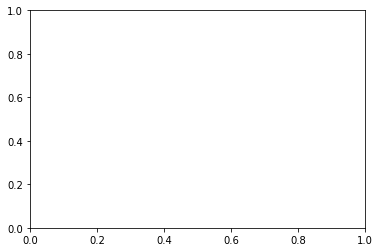

In [8]:
plt.plot((w[d_ind].data),-(depth[:11]))

print np.mean(np.diff(w[d_ind])/np.diff(depth[:11]))
print np.trapz(np.diff(w[d_ind])/np.diff(depth[:11]))

In [ ]:
# sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
# import cmocean as cmap

# fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')

# #MLD_sept_mean[MLD_sept_mean == 0] = np.nan
# data, elem_no_nan = pf.get_data(12*30*uDN_node/ind_cnt,mesh,0)
# ax1      = fig.add_subplot(111)
# contours = np.arange(-1, 1, .1)
# m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
# x, y = m(mesh.x2, mesh.y2)
# plabels=[False,False,False,False]
# mlabels=[False,False,False,False]    
# m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
# m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
# m.drawmapboundary(fill_color='0.7')
# m.fillcontinents(color='.5',lake_color='.7')
# im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
# label = 'Nutrient limitation occurence [%]'
# cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
# cbar.set_label(label, fontsize=14)
# cbar.ax.tick_params(labelsize=12)
# plt.title('Nutrient limitation', fontsize=16)